In [162]:
import os

# Define paths
source_dir = 'path/to/source_dir'
reference_dir = 'path/to/reference_dir'

# Get the filenames in source
source_files = set(os.listdir(source_dir))

# Loop over reference directory and delete files not in source
for filename in os.listdir(reference_dir):
    if filename not in source_files:
        file_path = os.path.join(reference_dir, filename)
        print(f"Deleting {file_path}")
        os.remove(file_path)


In [163]:
def calculate_pos_entropy(all_pos, all_neg, num_features):
    if len(all_pos) != len(all_neg):
        print("error")
        return 0

    total_runs = len(all_pos)
    pos_features = np.unique(np.concatenate(all_pos))
    neg_features = np.unique(np.concatenate(all_neg))
    merged_features = np.unique(np.concatenate((pos_features, neg_features)))

    pos_counter = Counter(np.concatenate(all_pos))
    neg_counter = Counter(np.concatenate(all_neg))

    sign_entropies = []
    for f in merged_features:
        pos_count = pos_counter[f]
        neg_count = neg_counter[f]
        p_pos = pos_count / (pos_count + neg_count)
        p_neg = neg_count / (pos_count + neg_count)

        if p_pos == 0 or p_neg == 0:
            entropy = 0
        else:
            entropy = -p_pos * np.log2(p_pos) - p_neg * np.log2(p_neg)
        sign_entropies.append(entropy)

    avg_entropy = np.sum(sign_entropies) / num_features
    if len(merged_features) < 0.5 * num_features and avg_entropy == 0:
        avg_entropy += 0.1 * ((num_features - len(merged_features)) / num_features)
    return sign_entropies, avg_entropy


def calculate_mean_rbo(pos_all, neg_all, persistence=0.2):
    def pairwise_rbo(lists):
        total_rbo, count = 0, 0
        for i in range(len(lists)):
            for j in range(len(lists)):
                l1, l2 = lists[i], lists[j]
                if l1 is None or l2 is None or len(l1) == 0 or len(l2) == 0:
                    total_rbo += 1 if len(l1) == 0 and len(l2) == 0 else 0
                else:
                    total_rbo += rbo.RankingSimilarity(l1, l2).rbo_ext(p=persistence)
                count += 1
        return total_rbo / count if count > 0 else 1.0

    return pairwise_rbo(pos_all), pairwise_rbo(neg_all)


def calculate_asfe_and_arsc(files, img_info_dict, model_name):
    all_asfe, all_arsc = [], []

    for file in files:
        with open(file, 'rb') as f:
            data = pickle.load(f)

        for img in data.keys():
            run_dict = data[img][0]
            num_segments = len(np.unique(img_info_dict[model_name + "_" + img.split("run_")[1]][0]['segments']))

            all_pos, all_neg = [], []
            for run in run_dict:
                run_info = run_dict[run][0]
                key_pos = 'pos' if 'pos' in run_info else 'pos_borda'
                key_neg = 'neg' if 'neg' in run_info else 'neg_borda'

                if run_info[key_pos] is not None:
                    all_pos.append(np.sort(run_info[key_pos]))
                if run_info[key_neg] is not None:
                    all_neg.append(np.sort(run_info[key_neg]))

            # ASFE
            if all(np.array_equal(p, all_pos[0]) for p in all_pos) and all(np.array_equal(n, all_neg[0]) for n in all_neg):
                sign_entropy = 0
            else:
                sign_entropy = calculate_pos_entropy(all_pos, all_neg, num_segments)[1]

            all_asfe.append(sign_entropy)

            # ARSC
            rbo_pos, rbo_neg = calculate_mean_rbo(all_pos, all_neg)
            arsc = (rbo_pos + rbo_neg) / 2
            all_arsc.append(arsc)

    return np.array(all_asfe), np.array(all_arsc)

In [90]:
# === PLOTTING CCM ECDFs FOR EACH ZETA ===
# Set professional style
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

# Setup
zeta_range = [f"zeta{i}" for i in [0,1,5,9,10]]  # zeta0 to zeta6
results_dir = "Z:/Desktop/bayesian_sem_regression/vit_slice/results_rebuttal/oxpets/semlime_resnet50/"
img_info_filepath = "img_info_dict/imgs_info.pkl"
model_name = "resnet50"
dataset = "oxpets"

with open(img_info_filepath, 'rb') as f:
    img_info_dict = pickle.load(f)

ccm_dict = {}

for zeta in zeta_range:
    pattern = os.path.join(results_dir, f"{dataset}_semlime_*_{model_name}_{zeta}.pkl")
    files = glob.glob(pattern)
    print(f"[{zeta}] Found {len(files)} files")

    if not files:
        continue

    asfe, arsc = calculate_asfe_and_arsc(files, img_info_dict, model_name)
    ccm_scores = arsc * (1 - asfe)
    ccm_scores = ccm_scores[~np.isnan(ccm_scores)]
    ccm_dict[zeta] = ccm_scores
    print(f"{zeta}: CCM mean={np.round(np.mean(ccm_scores), 3)}, n={len(ccm_scores)}")

[zeta0] Found 50 files
zeta0: CCM mean=0.961, n=50
[zeta1] Found 50 files
zeta1: CCM mean=0.917, n=50
[zeta5] Found 50 files
zeta5: CCM mean=0.91, n=50
[zeta9] Found 50 files
zeta9: CCM mean=0.913, n=50
[zeta10] Found 50 files
zeta10: CCM mean=0.908, n=50


In [41]:
import pickle
metric_name = '1-asfe'
pkl_filename = 'fidelity_results_rebuttal/' + metric_name + '_rebuttal.pkl'
with open(pkl_filename, "rb") as f:
    ccm_dict = pickle.load(f)

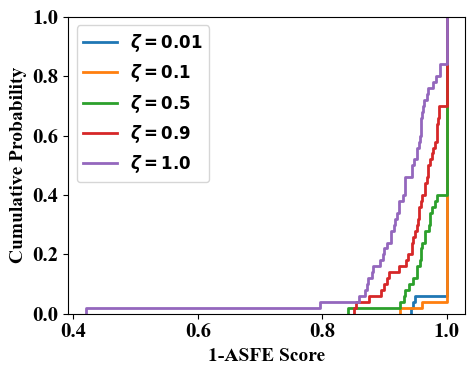

In [42]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# === PLOT ===
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'bold'

plt.figure(figsize=(5, 4))
colors = sns.color_palette("tab10", n_colors=len(ccm_dict))

for i, zeta in enumerate(sorted(ccm_dict.keys(), key=lambda x: int(x.replace("zeta", "")))):
    idx = int(zeta.replace("zeta", ""))          # 0, 1, 2, …
    display = 0.01 if idx == 0 else idx / 10     # 0.01, 0.1, 0.2, …
    z_lbl = rf"$\zeta = {display}$"               # TeX label

    sns.ecdfplot(ccm_dict[zeta], label=z_lbl,
                 color=colors[i], linewidth=2)
    #sns.ecdfplot(ccm_dict[zeta], label=zeta, color=colors[i], linewidth=2)

plt.xlabel(f"{metric_name.upper()} Score", fontsize=14, fontweight='bold')
plt.ylabel("Cumulative Probability", fontsize=14, fontweight='bold')
#plt.title(f"ECDF of CCM Scores for Zetas (SEMLIME, {model_name}, {dataset})", fontsize=14, fontweight='bold')
#plt.legend(title="Zeta Variant")
plt.legend(fontsize=12)
plt.tight_layout()

os.makedirs("plots_zeta", exist_ok=True)
plt.savefig(f"plots_zeta/{metric_name}_ecdf_zeta0to6.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
###### Adversarial

# === PLOTTING CCM ECDFs FOR EACH ZETA ===
# Set professional style
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

# Setup
zeta_range = [f"zeta{i}" for i in [0,1,5,9,10]]  # zeta0 to zeta6
results_dir = "Z:/Desktop/bayesian_sem_regression/vit_slice/results_rebuttal/oxpets/semlime_resnet50/"
img_info_filepath = "img_info_dict/imgs_info.pkl"
model_name = "resnet50"
dataset = "oxpets"

with open(img_info_filepath, 'rb') as f:
    img_info_dict = pickle.load(f)

ccm_dict = {}

for zeta in zeta_range:
    pattern = os.path.join(results_dir, f"{dataset}_semlime_*_{model_name}_{zeta}.pkl")
    files = glob.glob(pattern)
    print(f"[{zeta}] Found {len(files)} files")

    if not files:
        continue

    asfe, arsc = calculate_asfe_and_arsc(files, img_info_dict, model_name)
    ccm_scores = arsc * (1 - asfe)
    ccm_scores = ccm_scores[~np.isnan(ccm_scores)]
    ccm_dict[zeta] = ccm_scores
    print(f"{zeta}: CCM mean={np.round(np.mean(ccm_scores), 3)}, n={len(ccm_scores)}")

In [18]:
import os
import pickle
import numpy as np
from collections import defaultdict

# Path setup
results_dir = "results_rebuttal_idun/oxpets/semlime_resnet50/"
#"Z:/Desktop/bayesian_sem_regression/vit_slice/results_rebuttal/oxpets/semlime_resnet50/"
xai_name = "semlime"
model_name = "resnet50"
dataset_name = "oxpets"
img_info_path = "img_info_dict/imgs_info.pkl"

# Load image segmentation info
with open(img_info_path, 'rb') as f:
    img_info_dict = pickle.load(f)

# Structure to store fraction of features selected: {zeta: [(img_name, fraction), ...]}
zeta_fraction_dict = defaultdict(list)

for file in os.listdir(results_dir):
    #if not file.endswith(".pkl") or not xai_name in file or not model_name in file or not dataset_name in file:
    #    continue

    #print(os.path.join(results_dir, file))
    with open(os.path.join(results_dir, file), 'rb') as f:
        data = pickle.load(f)

    for img_key in data:
        # Extract zeta and image ID
        parts = img_key.split('_')
        zeta = file.split('_')[-1].replace('.pkl','')# e.g., zeta0
        image_id = str(img_key).replace('run_','')  # e.g., beagle_202

        model_key = model_name + "_" + image_id
        if model_key not in img_info_dict:
            continue

        num_segments = len(np.unique(img_info_dict[model_key][0]['segments']))
        img_data = data[img_key]

        frac_sel_segs = []
        for run_key in img_data[0].keys():
            frac_sel_segs.append((len(img_data[0]['run_0'][0]['pos']) + len(img_data[0]['run_0'][0]['neg']))/num_segments)

        if frac_sel_segs:
            avg_fraction = np.mean(frac_sel_segs)
            zeta_fraction_dict[zeta].append((image_id, avg_fraction))

In [19]:
zeta_fraction_dict.keys()

dict_keys(['zeta0', 'zeta1', 'zeta10', 'zeta2', 'zeta3', 'zeta4', 'zeta5', 'zeta6', 'zeta7', 'zeta8', 'zeta9'])

C:\Users\revotipb\AppData\Local\Temp\ipykernel_24616\1491439983.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=zeta_labels, y=median_fractions, palette="tab10")


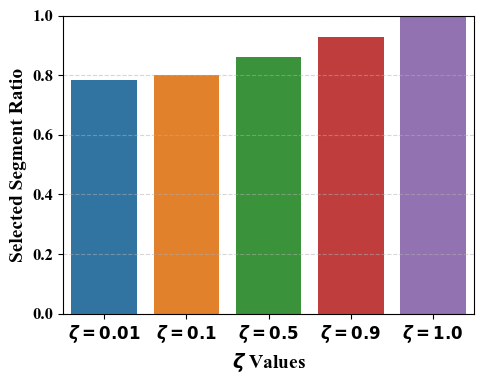

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === PLOT ===
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'

# Compute median fraction for each zeta
zeta_range = ['zeta0', 'zeta1', 'zeta5', 'zeta9', 'zeta10']
zeta_labels = []
median_fractions = []

for zeta in zeta_range: #sorted(zeta_fraction_dict.keys(), key=lambda x: int(x.replace("zeta", ""))):
    fractions = [frac for _, frac in zeta_fraction_dict[zeta]]
    median_fraction = np.mean(fractions)
    zeta_index = int(zeta.replace("zeta", ""))
    if zeta_index == 0:
        legend_label = r"$\zeta = 0.01$"
    else:
        legend_label = rf"$\zeta = {zeta_index / 10:.1f}$"
    zeta_labels.append(legend_label)
    median_fractions.append(median_fraction)

# Plot
plt.figure(figsize=(5, 4))
sns.barplot(x=zeta_labels, y=median_fractions, palette="tab10")

plt.xlabel(r"$\zeta$ Values", fontsize=14, fontweight='bold')
plt.ylabel("Selected Segment Ratio", fontsize=14, fontweight='bold')
#plt.title("Median Fraction of Features Selected per Zeta Variant", fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save or display
plt.savefig("plots_zeta/mean_fraction_selected_per_zeta.jpeg", format='png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\revotipb\AppData\Local\Temp\ipykernel_24616\3221374139.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=zeta_labels,


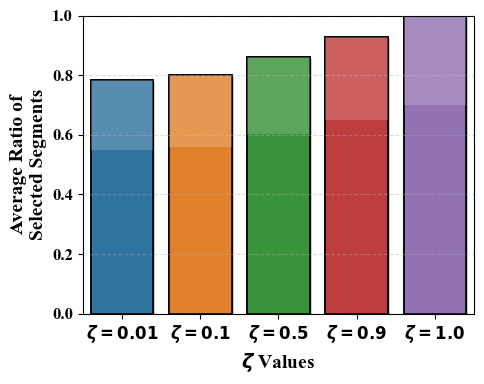

In [24]:
import os, pickle, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import seaborn as sns

# --------------- matplotlib style ---------------------------------
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"]   = 12
mpl.rcParams["font.weight"] = "bold"

# --------------- example data (replace with your dict) ------------
# zeta_fraction_dict = { ... }
zeta_range  = ['zeta0', 'zeta1', 'zeta5', 'zeta9', 'zeta10']
zeta_labels = []
avg_frac    = []

for z in zeta_range:
    fracs = [f for _, f in zeta_fraction_dict[z]]
    avg_frac.append(float(np.mean(fracs)))

    znum = int(z.replace("zeta", ""))
    label = r"$\zeta = 0.01$" if znum == 0 else rf"$\zeta = {znum/10:.1f}$"
    zeta_labels.append(label)

# --------------- bar plot with faux-3-D bevel ---------------------
colors = sns.color_palette("tab10", len(zeta_labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = sns.barplot(x=zeta_labels,
                   y=avg_frac,
                   palette=colors,
                   ax=ax,
                   edgecolor="black",
                   linewidth=1.2)

ax.set_xlabel(r"$\zeta$ Values", fontsize=14, weight="bold")
ax.set_ylabel("Average Ratio of\nSelected Segments",
              fontsize=14, weight="bold")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.4)

# ---------- add bevel: shadow + highlight -------------------------
for patch in ax.patches:
    # ➊ Drop-shadow path effect (offset slightly down/right)
    patch.set_path_effects([
        pe.withSimplePatchShadow(offset=(1.5, -1.5),
                                 shadow_rgbFace=(0.35, 0.35, 0.35, 0.45),
                                 alpha=None),
        pe.Normal()
    ])

    # ➋ Light highlight on the top 30 % of the bar
    x, y   = patch.get_xy()
    w      = patch.get_width()
    h      = patch.get_height()
    top_h  = 0.30 * h                    # height of highlight strip
    highlight = mpatches.Rectangle((x, y + h - top_h),
                                   w, top_h,
                                   facecolor="white",
                                   alpha=0.18,
                                   linewidth=0,
                                   zorder=patch.get_zorder()+1)
    ax.add_patch(highlight)

plt.tight_layout()
os.makedirs("plots_zeta", exist_ok=True)
plt.savefig("plots_zeta/mean_fraction_selected_per_zeta_bevel.pdf",
            dpi=300, bbox_inches="tight")
plt.show()

C:\Users\revotipb\AppData\Local\Temp\ipykernel_17300\1763729447.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=plot_labels, y=plot_data, jitter=0.2, palette="tab10", size=5, alpha=0.7)


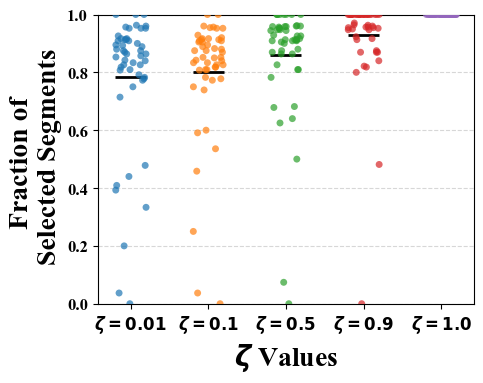

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# === STYLE ===
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'

# Prepare data
plot_data = []
plot_labels = []
mean_values = {}

for zeta in zeta_range:
    fractions = [frac for _, frac in zeta_fraction_dict[zeta]]
    zeta_index = int(zeta.replace("zeta", ""))
    label = r"$\zeta = 0.01$" if zeta_index == 0 else rf"$\zeta = {zeta_index / 10:.1f}$"
    
    plot_data.extend(fractions)
    plot_labels.extend([label] * len(fractions))
    mean_values[label] = np.mean(fractions)

# Create figure
plt.figure(figsize=(5, 4))
ax = sns.stripplot(x=plot_labels, y=plot_data, jitter=0.2, palette="tab10", size=5, alpha=0.7)

# Add horizontal mean lines
for i, (label, mean_val) in enumerate(mean_values.items()):
    ax.hlines(y=mean_val, xmin=i - 0.2, xmax=i + 0.2, color='black', linestyle='-', linewidth=2, label=f"Mean {label}")

# Labels and style
plt.xlabel(r"$\zeta$ Values", fontsize=20, fontweight='bold')
plt.ylabel("Fraction of \n Selected Segments", fontsize=20, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save or display
plt.savefig("plots_zeta/strip_fraction_selected_per_zeta.jpeg", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [97]:
# Structure to store fraction of features selected: {zeta: [(img_name, fraction), ...]}


In [112]:
### coef spread
import os
import pickle
import numpy as np
from collections import defaultdict

# Path setup
results_dirs = [
    "Z:/Desktop/bayesian_sem_regression/vit_slice/results/oxpets/sliceblurfe_resnet50/",
    "Z:/Desktop/bayesian_sem_regression/vit_slice/results/oxpets/semlime_resnet50/",
    #"Z:/Desktop/bayesian_sem_regression/vit_slice/results/oxpets/baylime_resnet50/"
    "Z:/Desktop/bayesian_sem_regression/vit_slice/results/oxpets/lime_resnet50/"
]
xai_names = ["sliceblurfe", "semlime", "lime"] #["sliceblurfe", "semlime", "baylime", "lime"]
model_name = "resnet50"
dataset_name = "oxpets"
img_info_path = "img_info_dict/imgs_info.pkl"

# Output dictionary
zeta_mean_mu_dict = defaultdict(list)

# Load image segmentation info
with open(img_info_path, 'rb') as f:
    img_info_dict = pickle.load(f)

# Iterate over result directories
for results_dir, xai_name in zip(results_dirs, xai_names):
    for file in os.listdir(results_dir):
        #if not file.endswith(".pkl") or xai_name not in file or model_name not in file or dataset_name not in file:
        #    continue

        with open(os.path.join(results_dir, file), 'rb') as f:
            data = pickle.load(f)

        for img_key in data:
            image_id = str(img_key).replace('run_', '')  # e.g., beagle_202
            model_key = model_name + "_" + image_id
            if model_key not in img_info_dict:
                continue

            num_segments = len(np.unique(img_info_dict[model_key][0]['segments']))
            img_data = data[img_key]
            coeff_matrix = np.ones((20, num_segments)) * -1

            for run_idx, run_key in enumerate(img_data[0].keys()):
                run_info = img_data[0][run_key][0]

                # Handle pos_dict
                pos_dict = run_info.get('pos_dict', {})
                if 'column_names' in pos_dict and 'column_means' in pos_dict:
                    pos_cols = list(pos_dict['column_names'])  # Convert to list
                    pos_vals = pos_dict['column_means']
                    coeff_matrix[run_idx, pos_cols] = pos_vals

                # Handle neg_dict
                neg_dict = run_info.get('neg_dict', {})
                if 'column_names' in neg_dict and 'column_means' in neg_dict:
                    neg_cols = list(neg_dict['column_names'])  # Convert to list
                    neg_vals = neg_dict['column_means']
                    coeff_matrix[run_idx, neg_cols] = neg_vals

            # Calculate stats
            col_means = np.mean(coeff_matrix, axis=0)
            col_stds = np.std(coeff_matrix, axis=0)

            cov = np.zeros_like(col_means)
            nonzero_mask = col_stds != 0
            cov[nonzero_mask] = abs(col_means[nonzero_mask]) / col_stds[nonzero_mask]
            zero_columns = np.all(coeff_matrix == 0, axis=0)
            cov[zero_columns] = 0

            valid_cols_mask = np.any(coeff_matrix != -1, axis=0)
            valid_means = col_means[valid_cols_mask]
            valid_stds = col_stds[valid_cols_mask]

            zeta_mean_mu_dict[xai_name].append((np.mean(valid_means), np.mean(valid_stds)))

            print(f"{file} ({xai_name}): Mean STD = {np.mean(valid_stds):.4f}")

oxpets_sliceblurfe_beagle_202_resnet50.pkl (sliceblurfe): Mean STD = 0.0329
oxpets_sliceblurfe_Bengal_145_resnet50.pkl (sliceblurfe): Mean STD = 0.0000
oxpets_sliceblurfe_Bengal_62_resnet50.pkl (sliceblurfe): Mean STD = 0.0394
oxpets_sliceblurfe_Birman_128_resnet50.pkl (sliceblurfe): Mean STD = 0.0313
oxpets_sliceblurfe_Birman_148_resnet50.pkl (sliceblurfe): Mean STD = 0.0333
oxpets_sliceblurfe_Birman_157_resnet50.pkl (sliceblurfe): Mean STD = 0.0000
oxpets_sliceblurfe_Birman_34_resnet50.pkl (sliceblurfe): Mean STD = 0.0095
oxpets_sliceblurfe_Bombay_205_resnet50.pkl (sliceblurfe): Mean STD = 0.0000
oxpets_sliceblurfe_Bombay_37_resnet50.pkl (sliceblurfe): Mean STD = 0.0000
oxpets_sliceblurfe_boxer_129_resnet50.pkl (sliceblurfe): Mean STD = 0.0361
oxpets_sliceblurfe_boxer_178_resnet50.pkl (sliceblurfe): Mean STD = 0.0000
oxpets_sliceblurfe_British_Shorthair_154_resnet50.pkl (sliceblurfe): Mean STD = 0.0460
oxpets_sliceblurfe_British_Shorthair_174_resnet50.pkl (sliceblurfe): Mean STD = 0.

C:\Users\revotipb\Miniconda3\envs\belief\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\revotipb\Miniconda3\envs\belief\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


oxpets_semlime_Sphynx_173_resnet50.pkl (semlime): Mean STD = 0.0121
oxpets_semlime_Sphynx_176_resnet50.pkl (semlime): Mean STD = 0.0296
oxpets_semlime_staffordshire_bull_terrier_40_resnet50.pkl (semlime): Mean STD = 0.0104
oxpets_semlime_wheaten_terrier_117_resnet50.pkl (semlime): Mean STD = 0.0359
oxpets_semlime_wheaten_terrier_169_resnet50.pkl (semlime): Mean STD = 0.0000
oxpets_semlime_wheaten_terrier_79_resnet50.pkl (semlime): Mean STD = 0.0233
oxpets_semlime_wheaten_terrier_94_resnet50.pkl (semlime): Mean STD = 0.0250
oxpets_semlime_yorkshire_terrier_112_resnet50.pkl (semlime): Mean STD = 0.0128
oxpets_semlime_yorkshire_terrier_98_resnet50.pkl (semlime): Mean STD = 0.0582
oxpets_lime_beagle_202_resnet50.pkl (lime): Mean STD = 0.1976
oxpets_lime_Bengal_145_resnet50.pkl (lime): Mean STD = 0.1372
oxpets_lime_Bengal_62_resnet50.pkl (lime): Mean STD = 0.0897
oxpets_lime_Birman_128_resnet50.pkl (lime): Mean STD = 0.1726
oxpets_lime_Birman_148_resnet50.pkl (lime): Mean STD = 0.1533
oxpet

In [114]:
zeta_mean_mu_dict.keys()

dict_keys(['sliceblurfe', 'semlime', 'lime', 'slice'])

semlime: 49 samples
sliceblurfe: 49 samples
lime: 49 samples


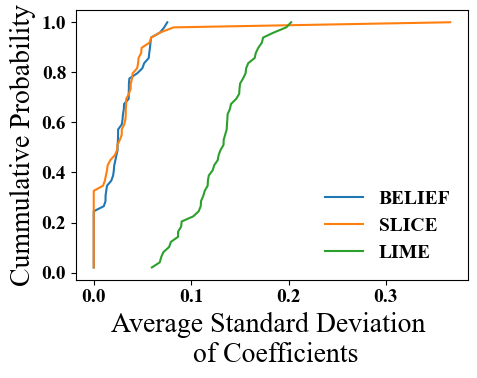

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Set professional style
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

# List of keys in the dict and corresponding method names
zeta_range = ['semlime', 'sliceblurfe', 'lime']
methods = ['BELIEF', 'SLICE', 'LIME']

# ECDF plot
plt.figure(figsize=(5, 4))


for zeta, method in zip(zeta_range, methods):
    
    #stds = [std for (mean, std) in zeta_mean_mu_dict[zeta]]
    stds = [s for (m, s) in zeta_mean_mu_dict[zeta] if not np.isnan(s)]
    means = [m for (m, s) in zeta_mean_mu_dict[zeta] if not np.isnan(s)]
    if len(stds) == 50:
        stds = stds[0:49]
    print(f"{zeta}: {len(stds)} samples")
    sorted_stds = np.sort(stds)
    
    #covs = np.array(sorted_stds)/np.array(means)
    
    #ecdf = np.arange(1, len(sorted_stds) + 1) / len(sorted_stds)
    ecdf = np.arange(1, len(sorted_stds) + 1) / 49  # where max_len = 50
    
    plt.plot(sorted_stds, ecdf, label=method)

plt.xlabel("Average Standard Deviation \n of Coefficients", fontsize=20)
plt.ylabel("Cummulative Probability", fontsize=20)
plt.legend(frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("plots_zeta/coef_std_BSL.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

semlime: 49 samples
sliceblurfe: 49 samples
lime: 49 samples


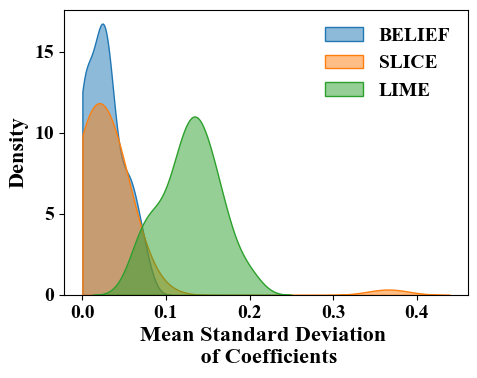

In [159]:
##### import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Set professional style
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

# List of keys in the dict and corresponding method names
zeta_range = ['semlime', 'sliceblurfe', 'lime']
methods = ['BELIEF', 'SLICE', 'LIME']

# KDE plot
plt.figure(figsize=(5, 4))

for zeta, method in zip(zeta_range, methods):
    stds = [s for (m, s) in zeta_mean_mu_dict[zeta] if not np.isnan(s)]
    
    if len(stds) == 50:
        stds = stds[:49]  # Matching original behavior

    print(f"{zeta}: {len(stds)} samples")
    
    sns.kdeplot(stds, label=method, linewidth=1, fill=True, alpha=0.5, clip=(0,0.5))

plt.xlabel("Mean Standard Deviation \n of Coefficients", fontsize=16, weight='bold')
plt.ylabel("Density", fontsize=16, weight='bold')
plt.legend(frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("plots_zeta/coef_std_BSL_kde.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

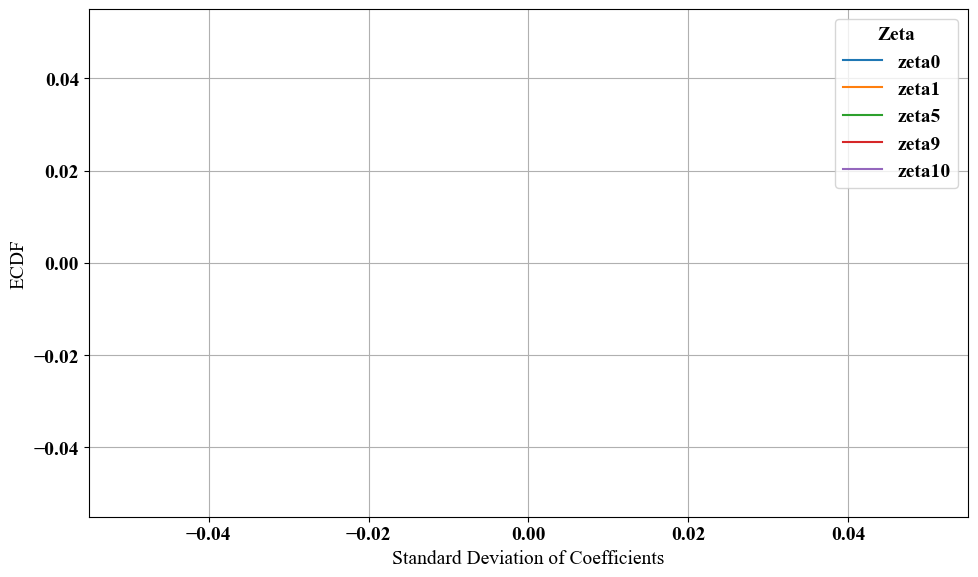

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# List of zetas you're interested in
zeta_range = [f"zeta{i}" for i in [0, 1, 5, 9, 10]]

# ECDF plot for each zeta
plt.figure(figsize=(10, 6))

for zeta in zeta_range:
    # Extract the list of (mean, std) pairs and take stds for ECDF
    stds = [std for (mean, std) in zeta_mean_mu_dict[zeta]]
    means = [mean for (mean, std) in zeta_mean_mu_dict[zeta]]
    # Sort std values
    sorted_stds = np.sort(means)
    ecdf = np.arange(1, len(sorted_stds) + 1) / len(sorted_stds)
    
    plt.plot(sorted_stds, ecdf, label=zeta)

plt.xlabel("Standard Deviation of Coefficients")
plt.ylabel("ECDF")
#plt.title("ECDF of Std Dev for Each Zeta")
plt.legend(title="Zeta")
plt.grid(True)
plt.tight_layout()
plt.show()

### ECDF Plot for Zeta 0 to 6

![ECDF](https://raw.githubusercontent.com/anonymousuai2025/belief/main/mean_fraction_selected_per_zeta.jpeg)


In [165]:
import os

# Define paths
source_dir = 'results_adversarial/oxpets/semlime_resnet50_adv/'
reference_dir = 'results_adversarial/oxpets/semlime_resnet50/'

# Get the filenames in source
source_files = set(os.listdir(source_dir))

# Loop over reference directory and delete files not in source
for filename in os.listdir(reference_dir):
    if filename not in source_files:
        file_path = os.path.join(reference_dir, filename)
        print(f"Deleting {file_path}")
        os.remove(file_path)


Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_miniature_pinscher_37_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_127_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_167_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_181_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_187_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_1_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_newfoundland_82_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_Persian_20_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_Persian_9_resnet50.pkl
Deleting results_adversarial/oxpets/semlime_resnet50/oxpets_semlime_pomeranian_116_resnet50.pkl
Deleting results_adversarial/oxpe

In [179]:
################Adversarial
import os
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import rbo
from collections import defaultdict
from scipy.stats import gaussian_kde
from numpy.linalg import LinAlgError
from collections import Counter

def calculate_pos_entropy(all_pos, all_neg, num_features):
    if len(all_pos) != len(all_neg):
        print("error")
        return 0

    total_runs = len(all_pos)
    pos_features = np.unique(np.concatenate(all_pos))
    neg_features = np.unique(np.concatenate(all_neg))
    merged_features = np.unique(np.concatenate((pos_features, neg_features)))

    pos_counter = Counter(np.concatenate(all_pos))
    neg_counter = Counter(np.concatenate(all_neg))

    sign_entropies = []
    for f in merged_features:
        pos_count = pos_counter[f]
        neg_count = neg_counter[f]
        p_pos = pos_count / (pos_count + neg_count)
        p_neg = neg_count / (pos_count + neg_count)

        if p_pos == 0 or p_neg == 0:
            entropy = 0
        else:
            entropy = -p_pos * np.log2(p_pos) - p_neg * np.log2(p_neg)
        sign_entropies.append(entropy)

    avg_entropy = np.sum(sign_entropies) / num_features
    if len(merged_features) < 0.5 * num_features and avg_entropy == 0:
        avg_entropy += 0.1 * ((num_features - len(merged_features)) / num_features)
    return sign_entropies, avg_entropy


def calculate_mean_rbo(pos_all, neg_all, persistence=0.2):
    def pairwise_rbo(lists):
        total_rbo, count = 0, 0
        for i in range(len(lists)):
            for j in range(len(lists)):
                l1, l2 = lists[i], lists[j]
                if l1 is None or l2 is None or len(l1) == 0 or len(l2) == 0:
                    total_rbo += 1 if len(l1) == 0 and len(l2) == 0 else 0
                else:
                    total_rbo += rbo.RankingSimilarity(l1, l2).rbo_ext(p=persistence)
                count += 1
        return total_rbo / count if count > 0 else 1.0

    return pairwise_rbo(pos_all), pairwise_rbo(neg_all)


def calculate_asfe_and_arsc(files, img_info_dict, model_name):
    all_asfe, all_arsc = [], []

    for file in files:
        with open(file, 'rb') as f:
            data = pickle.load(f)

        for img in data.keys():
            run_dict = data[img][0]
            num_segments = len(np.unique(img_info_dict[model_name + "_" + img.split("run_")[1]][0]['segments']))

            all_pos, all_neg = [], []
            for run in run_dict:
                run_info = run_dict[run][0]
                key_pos = 'pos' if 'pos' in run_info else 'pos_borda'
                key_neg = 'neg' if 'neg' in run_info else 'neg_borda'

                if run_info[key_pos] is not None:
                    all_pos.append(np.sort(run_info[key_pos]))
                if run_info[key_neg] is not None:
                    all_neg.append(np.sort(run_info[key_neg]))

            # ASFE
            if all(np.array_equal(p, all_pos[0]) for p in all_pos) and all(np.array_equal(n, all_neg[0]) for n in all_neg):
                sign_entropy = 0
            else:
                sign_entropy = calculate_pos_entropy(all_pos, all_neg, num_segments)[1]

            all_asfe.append(sign_entropy)

            # ARSC
            rbo_pos, rbo_neg = calculate_mean_rbo(all_pos, all_neg)
            arsc = (rbo_pos + rbo_neg) / 2
            all_arsc.append(arsc)

    return np.array(all_asfe), np.array(all_arsc)

# === PLOTTING CCM ECDFs FOR EACH ZETA ===
# Set professional style
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

# Setup

results_dirs = ["results_adversarial/oxpets/semlime_resnet50_adv/",
                "results_adversarial/oxpets/semlime_resnet50/"]

image_types = ['Original', 'Adversarial']

img_info_filepath = "img_info_dict/imgs_info.pkl"
model_name = "resnet50"
dataset = "oxpets"

with open(img_info_filepath, 'rb') as f:
    img_info_dict = pickle.load(f)

ccm_dict = {}

for results_dir, image_type in zip(results_dirs, image_types):
    pattern = os.path.join(results_dir, "*.pkl")
    files = glob.glob(pattern)

    if not files:
        continue

    asfe, arsc = calculate_asfe_and_arsc(files, img_info_dict, model_name)
    ccm_scores = arsc * (1 - asfe)
    ccm_scores = ccm_scores[~np.isnan(ccm_scores)]
    ccm_dict[image_type] = ccm_scores
    print(f"{image_type}: CCM mean={np.round(np.mean(ccm_scores), 2)}, n={len(ccm_scores)}")

Original: CCM mean=0.96, n=20
Adversarial: CCM mean=0.98, n=20


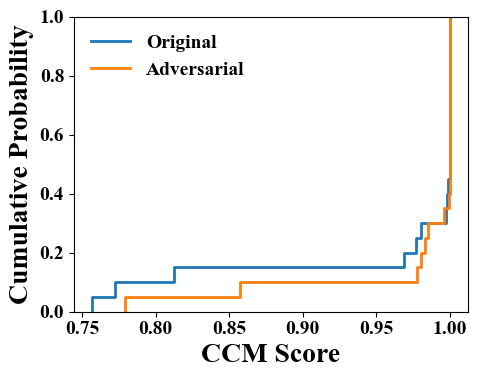

In [180]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# === PLOT ===
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'

plt.figure(figsize=(5, 4))
colors = sns.color_palette("tab10", n_colors=len(ccm_dict))

for i, image_type in enumerate(ccm_dict.keys()):
    sns.ecdfplot(ccm_dict[image_type], label=image_type, color=colors[i], linewidth=2)

plt.xlabel("CCM Score", fontsize=20, fontweight='bold')
plt.ylabel("Cumulative Probability", fontsize=20, fontweight='bold')
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

os.makedirs("plots_zeta", exist_ok=True)
plt.savefig("plots_zeta/ccm_ecdf_adversarial.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [181]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(ccm_dict['Original'], ccm_dict['Adversarial'])
print(f"{stat:.3f}, p = {p_value:.4f}")

64.000, p = 0.3491
